**Import Libraries**

In [5]:
#Normal distribution functions
from scipy.stats import norm


# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

**Black Scholes Formula**

In [6]:
true_alpha = 0.1
true_beta = 0.1
true_sigma0 = 0.2
interest = 0.05

def vol(moneyness, time):
    return true_sigma0 + true_alpha * time + true_beta * np.square(moneyness - 1)

def call_option_price(moneyness, time, option_vol):
    d1=(np.log(1/moneyness)+(interest + np.square(option_vol))*time)/(option_vol*np.sqrt(time))
    d2=(np.log(1/moneyness)+(interest - np.square(option_vol))*time)/(option_vol*np.sqrt(time))
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    
    return N_d1 - moneyness * np.exp(- interest * time) * N_d2

**Generating Data**

In [7]:
N = 10000

moneys = 1+0.25*np.random.randn(N)
times = np.random.random(N)
volatility = np.array([vol(k,t) for k,t in zip(moneys, times)])
prices = np.array([call_option_price(k,t,sig) for k,t,sig in zip(moneys, times, volatility)])
print('moneys', moneys)
print('times', times)
print('volatility', volatility)
print('prices', prices)

moneys [1.03270066 1.36519765 0.90017063 ... 1.07207945 1.19684273 1.09174856]
times [0.65523864 0.28458524 0.786723   ... 0.65220728 0.87219497 0.73281997]
volatility [0.2656308  0.24179546 0.27966889 ... 0.26574027 0.2910942  0.27412378]
prices [0.17049046 0.00474645 0.25080846 ... 0.15429537 0.15755684 0.16417986]


**Visualize**

[[1.03270066 0.65523864 0.2656308 ]
 [1.36519765 0.28458524 0.24179546]
 [0.90017063 0.786723   0.27966889]
 ...
 [1.07207945 0.65220728 0.26574027]
 [1.19684273 0.87219497 0.2910942 ]
 [1.09174856 0.73281997 0.27412378]]

[0.17049046 0.00474645 0.25080846 ... 0.15429537 0.15755684 0.16417986]

      Price  Moneyness      Time  Volatility
0  0.170490   1.032701  0.655239    0.265631
1  0.004746   1.365198  0.284585    0.241795
2  0.250808   0.900171  0.786723    0.279669
3  0.258891   0.849970  0.710604    0.273311
4  0.007869   1.035545  0.020895    0.202216


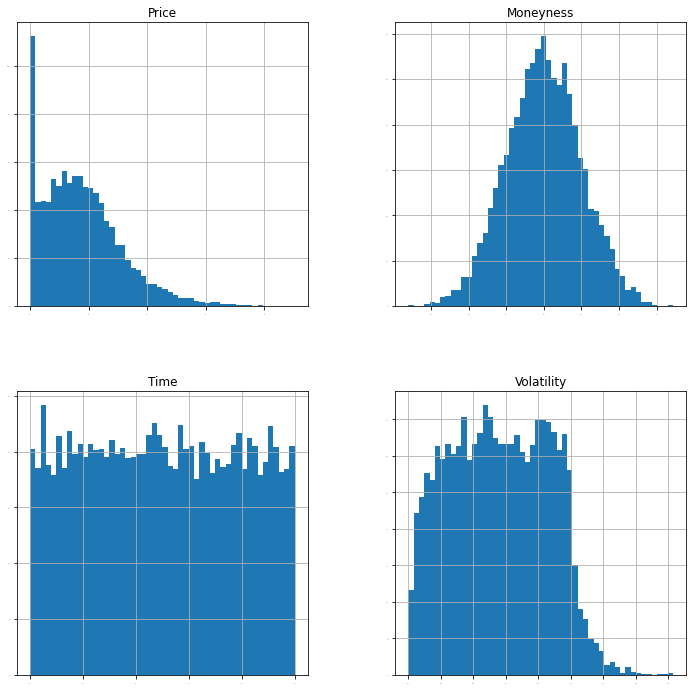

In [8]:
Y = prices
X = np.concatenate([moneys.reshape(-1,1), times.reshape(-1,1), volatility.reshape(-1,1)], axis=1)

dataset = pd.DataFrame(np.concatenate([Y.reshape(-1,1), X], axis=1),
                       columns=['Price', 'Moneyness', 'Time', 'Volatility'])
print(X)
print()
print(Y)
print()
print(dataset.head())
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

**Train Test Split**

In [9]:
#train-test = 80-20
validation_size = 0.2
train_size = int(len(X) * (1-validation_size))
print(train_size)
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

8000


**Models and K-fold Analysis**

In [10]:
models = []

#Linear Models and Regression Trees
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('DT', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

#Neural Network Predictor (Multi Layer Perceptron)
models.append(('MLP', MLPRegressor()))

# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

num_folds = 10
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds)
    
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.000352 (0.000027) 0.000351 0.000339
LASSO: 0.018301 (0.001300) 0.018293 0.017258
EN: 0.018301 (0.001300) 0.018293 0.017258
KNN: 0.000018 (0.000012) 0.000009 0.000011
DT: 0.000012 (0.000006) 0.000000 0.000008
SVR: 0.003922 (0.000086) 0.003881 0.003832
MLP: 0.000036 (0.000016) 0.000008 0.000006
ABR: 0.000663 (0.000044) 0.000718 0.000731
GBR: 0.000021 (0.000003) 0.000015 0.000017
RFR: 0.000003 (0.000003) 0.000000 0.000001
ETR: 0.000001 (0.000001) 0.000000 0.000000


**Results**

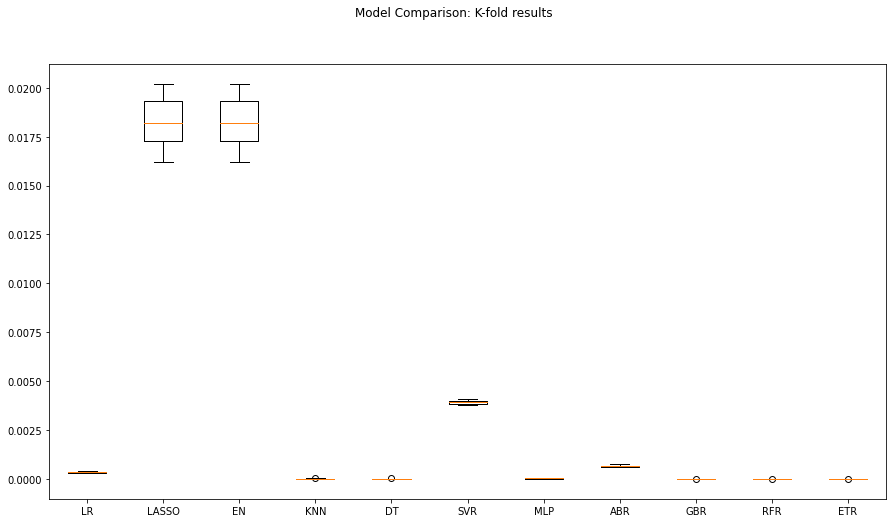

In [11]:
fig = pyplot.figure()
fig.suptitle('Model Comparison: K-fold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

**Remove LASSO and ElasticNet**

LR:   0.000351 0.000339
KNN:   0.000009 0.000011
DT:   0.000000 0.000008
SVR:   0.003881 0.003832
MLP:   0.000008 0.000006
ABR:   0.000718 0.000731
GBR:   0.000015 0.000017
RFR:   0.000000 0.000001
ETR:   0.000000 0.000000


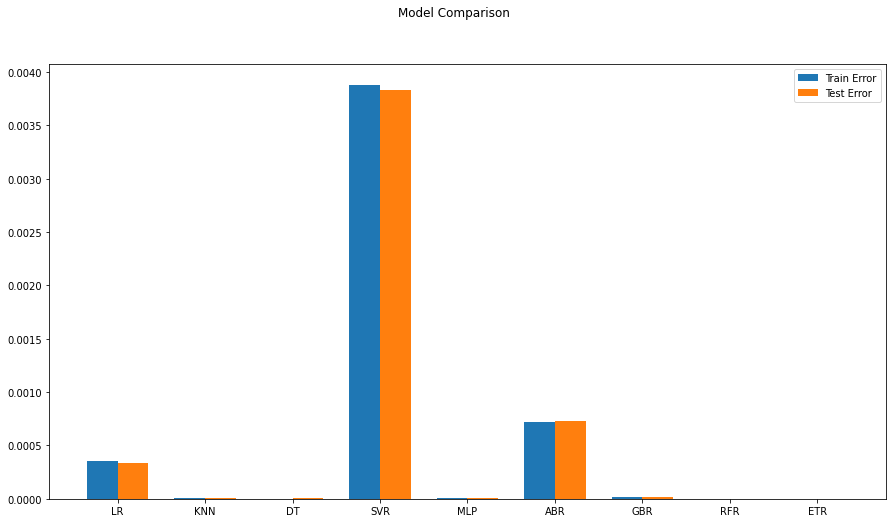

In [12]:
# compare algorithms
fig = pyplot.figure()
train = train_results[0:1] + train_results[3:]
test = test_results[0:1] + test_results[3:]
if 'LASSO' in names:
  names.remove('LASSO')
if 'EN' in names:
  names.remove('EN')

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars
fig.suptitle('Model Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
for i in range(len(train)):
  p = "%s: %10f %f" % (names[i], train[i], test[i])
  print(p)
pyplot.show()

**Improving MLP using GridSearchCV**

In [16]:
param_grid={'hidden_layer_sizes': [(20,), (50,), (20,20), (20, 30, 20)]}
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=MLPRegressor(), param_grid=param_grid, scoring=scoring, cv=kfold)
mlp = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (mlp.best_score_, mlp.best_params_))
print()
#improved MLP
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
predictions = mlp.predict(X_test)
print(mean_squared_error(Y_test, predictions))

Best: -0.000026 using {'hidden_layer_sizes': (20, 30, 20)}

1.37442628046282e-05
